# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Задание 8

**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`.
* Дедлайн **4 мая в 23:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` и все фотографии, если пишете теоретическую часть от руки.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

-----

*Замечания.* Теоретические решения можно оформить
* в $\LaTeX$-формате в ноутбуке;
* написать от руки и прикрепить к ноутбуку;
* написать от руки и выслать боту.  

Во втором случае также **важно** "вшить" фото в ноутбук. Сделать это можно с помощью Edit -> Insert Image в Jupyter или с помощью кнопки "Вставить изображение" в Colab. Следите за размером итогового файла.

Фотографии принимаются только в хорошем качестве, **следите за освещением и почерком**. На фотографиях также указывайте номера задач.

-----

**Работа Закировой Марфы, Б06-907**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.notebook import tqdm
sns.set(font_scale=1.3)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Задача 1: Белые мыши наносят ответный удар (продолжение)

Скачаем [данные](https://www.kaggle.com/ruslankl/mice-protein-expression) об экспрессии генов различных белков в головном мозге белых мышей.

В этом датасете представлены уровни экспрессии 77 белков, измеренные в коре головного мозга 8 классов мышей, некоторые из которых страдают синдромом Дауна, а некоторые были подвержены контекстному обусловливанию страха, задачи, используемой для оценки ассоциативного обучения.

Данные содержат информацию о 38 контрольных мышей и 34 трисомных мышей (синдром Дауна), то есть всего 72 мышки. Проведено 15 измерений каждого белка для каждой мышки, то есть каждой мыши соответствует несколько записей в таблице.

Загрузим данные и посмотрим на начало таблицы. Всего мы имеем 82 колонки, в большинстве их которых содержатся вещественные данные (уровни экспрессии 77 белков). Остальные колонки содержат категориальные данные (с небольшим числом значений).

**Предварительный анализ**

Эта часть цже оценена в прошлом дз, просто скопируйте графики.

In [2]:
data = pd.read_csv("./Data_Cortex_Nuclear.csv")
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


Чтобы вспомнить, что это за данные, для начала выведем простые описательные статистики по вещественным параметрам.

In [3]:
data.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1080.000000,867.000000,795.000000,1080.000000,1005.000000,1080.000000,900.000000,870.000000,810.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,...,0.028989,0.029537,0.027417,0.014276,0.023863,0.066432,0.059402,0.040406,0.055514,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,...,0.206395,0.136424,0.115554,0.110839,0.113506,0.398082,0.125848,0.155121,0.165143,1.081423
50%,0.366378,0.565782,0.316564,2.296546,3.760855,0.231177,0.182302,3.326520,0.210594,1.355846,...,0.224000,0.152313,0.129468,0.121626,0.126523,0.448459,0.158240,0.174935,0.193994,1.317441
75%,0.487711,0.698032,0.348197,2.528481,4.440011,0.257261,0.197418,4.481940,0.234595,1.561316,...,0.241655,0.174017,0.148235,0.131955,0.143652,0.490773,0.197876,0.204542,0.235215,1.585824
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.358289,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791


Количество записей каждого класса:

In [4]:
data['class'].value_counts()

c-CS-m    150
c-SC-m    150
c-CS-s    135
c-SC-s    135
t-CS-m    135
t-SC-m    135
t-SC-s    135
t-CS-s    105
Name: class, dtype: int64

Количество записей по генотипам:

In [5]:
data.Genotype.value_counts()

Control    570
Ts65Dn     510
Name: Genotype, dtype: int64

В начале исследования полезно посмотреть на данные визуально. Посмотрим на зависимость уровней экспрессии разных белков друг от друга. Визуализируйте данные в первых десяти колонках в двумерных проекциях, используя `sns.pairplot`. 

In [6]:
fav_columns = ['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N',
       'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N',
       'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N',
       'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N',
       'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N',
       'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N',
       'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N',
       'CaNA_N']

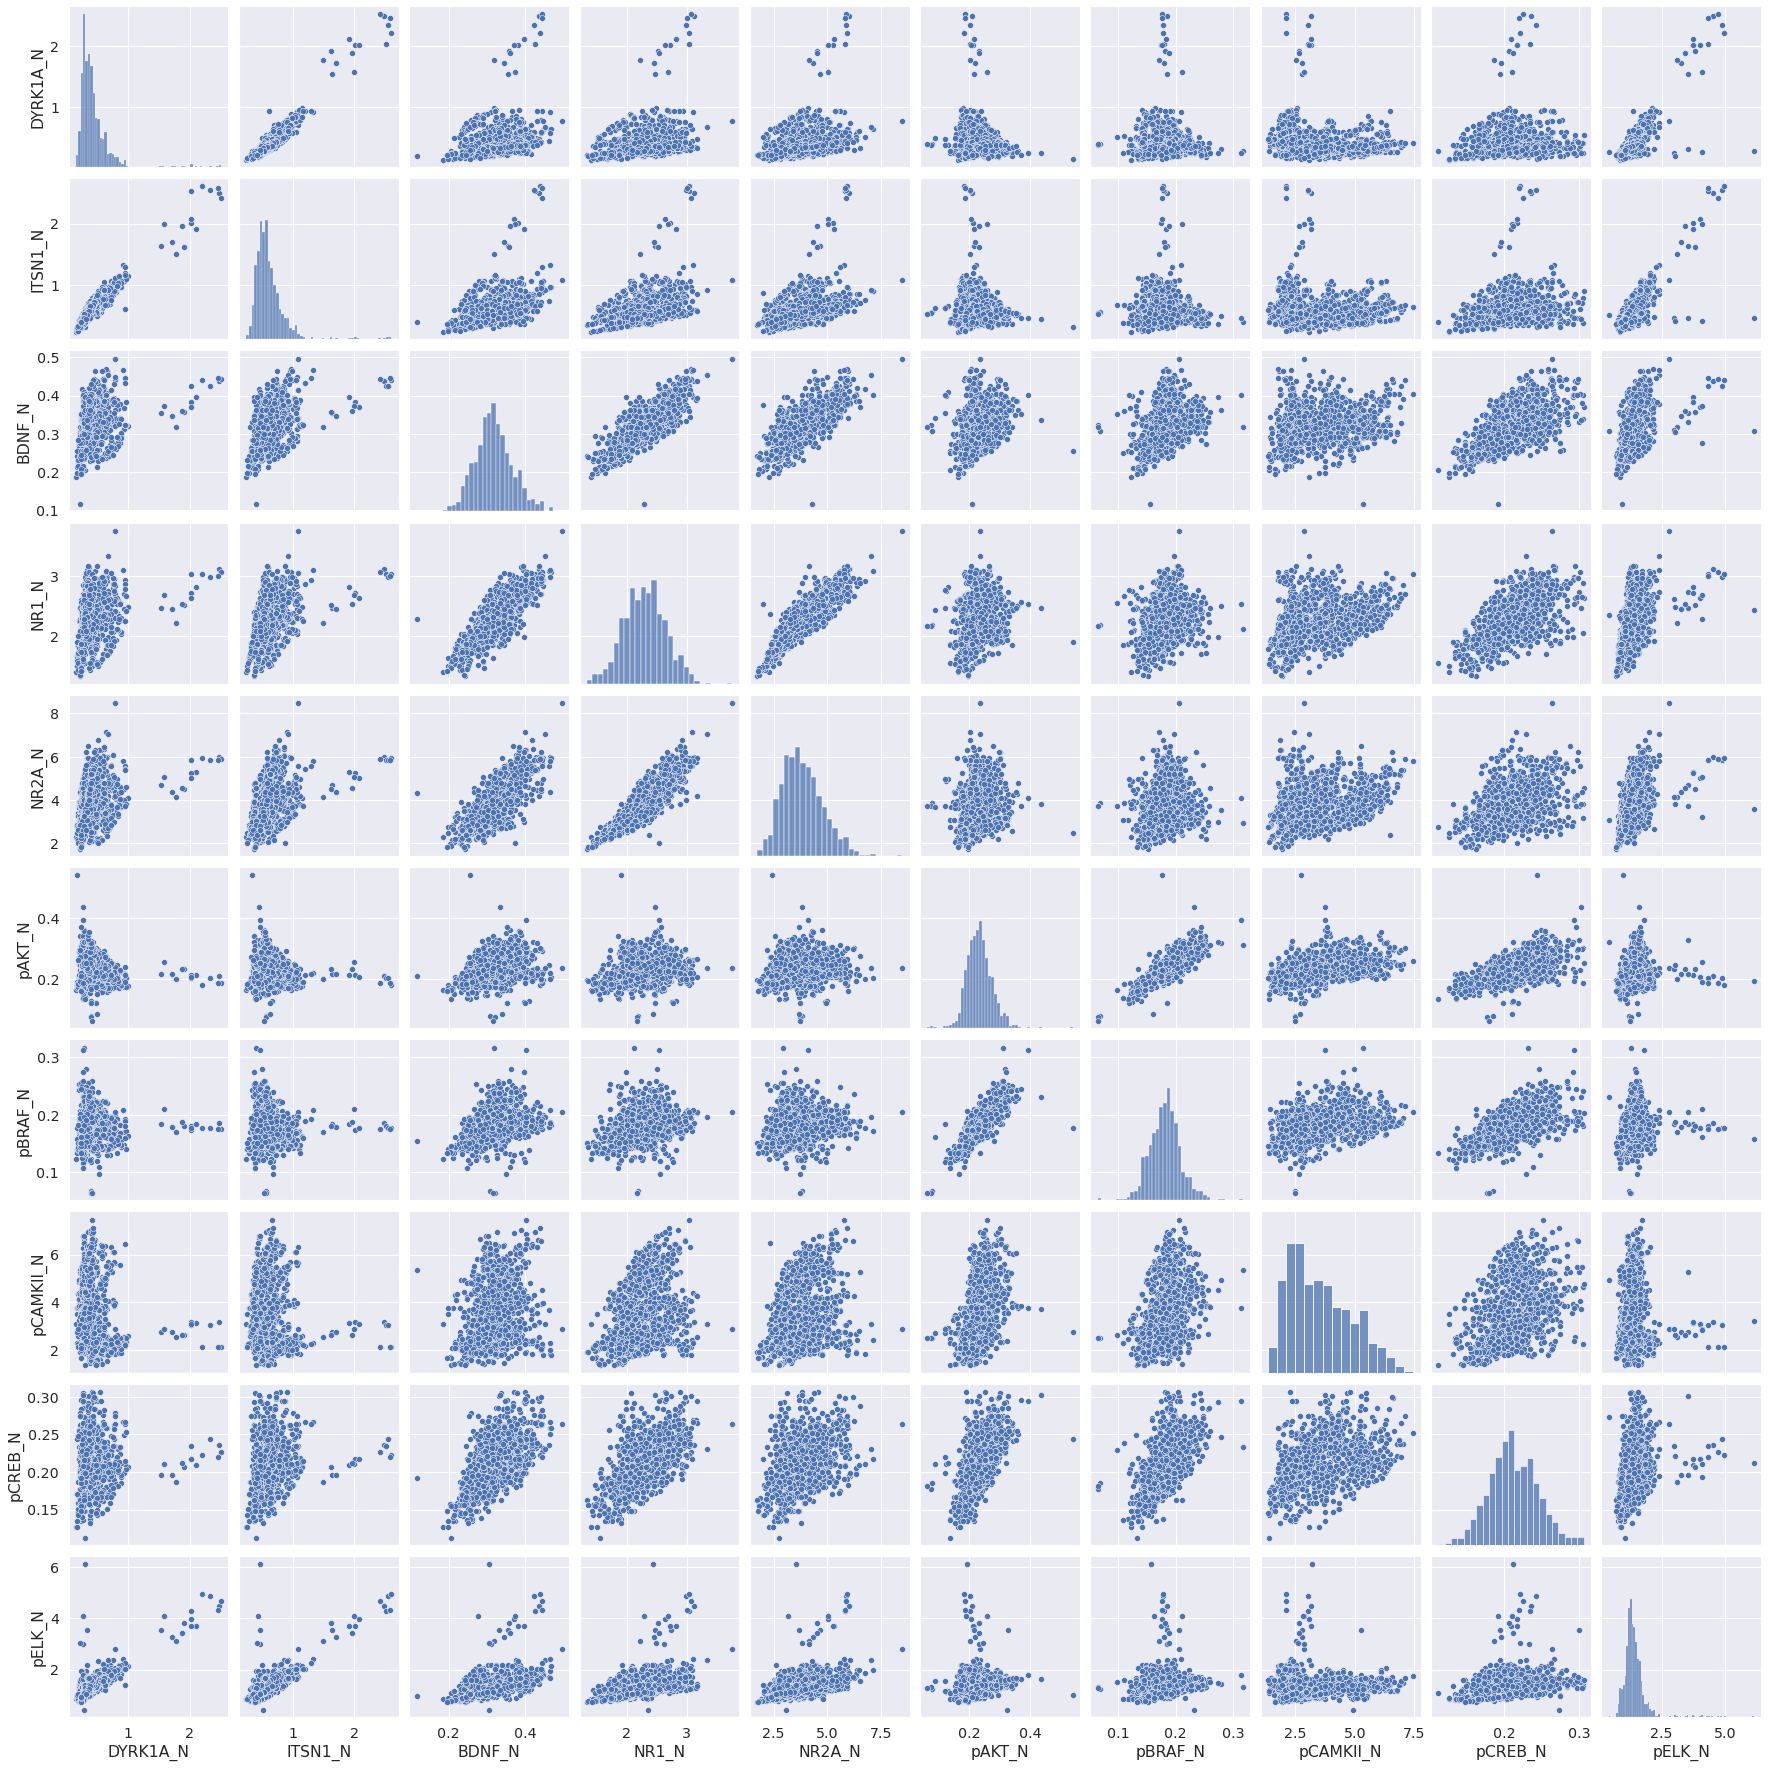

In [7]:
sns.pairplot(data[fav_columns[:10]])

При визуализации в двумерных проекциях можно также строить ядерные оценки плотности:

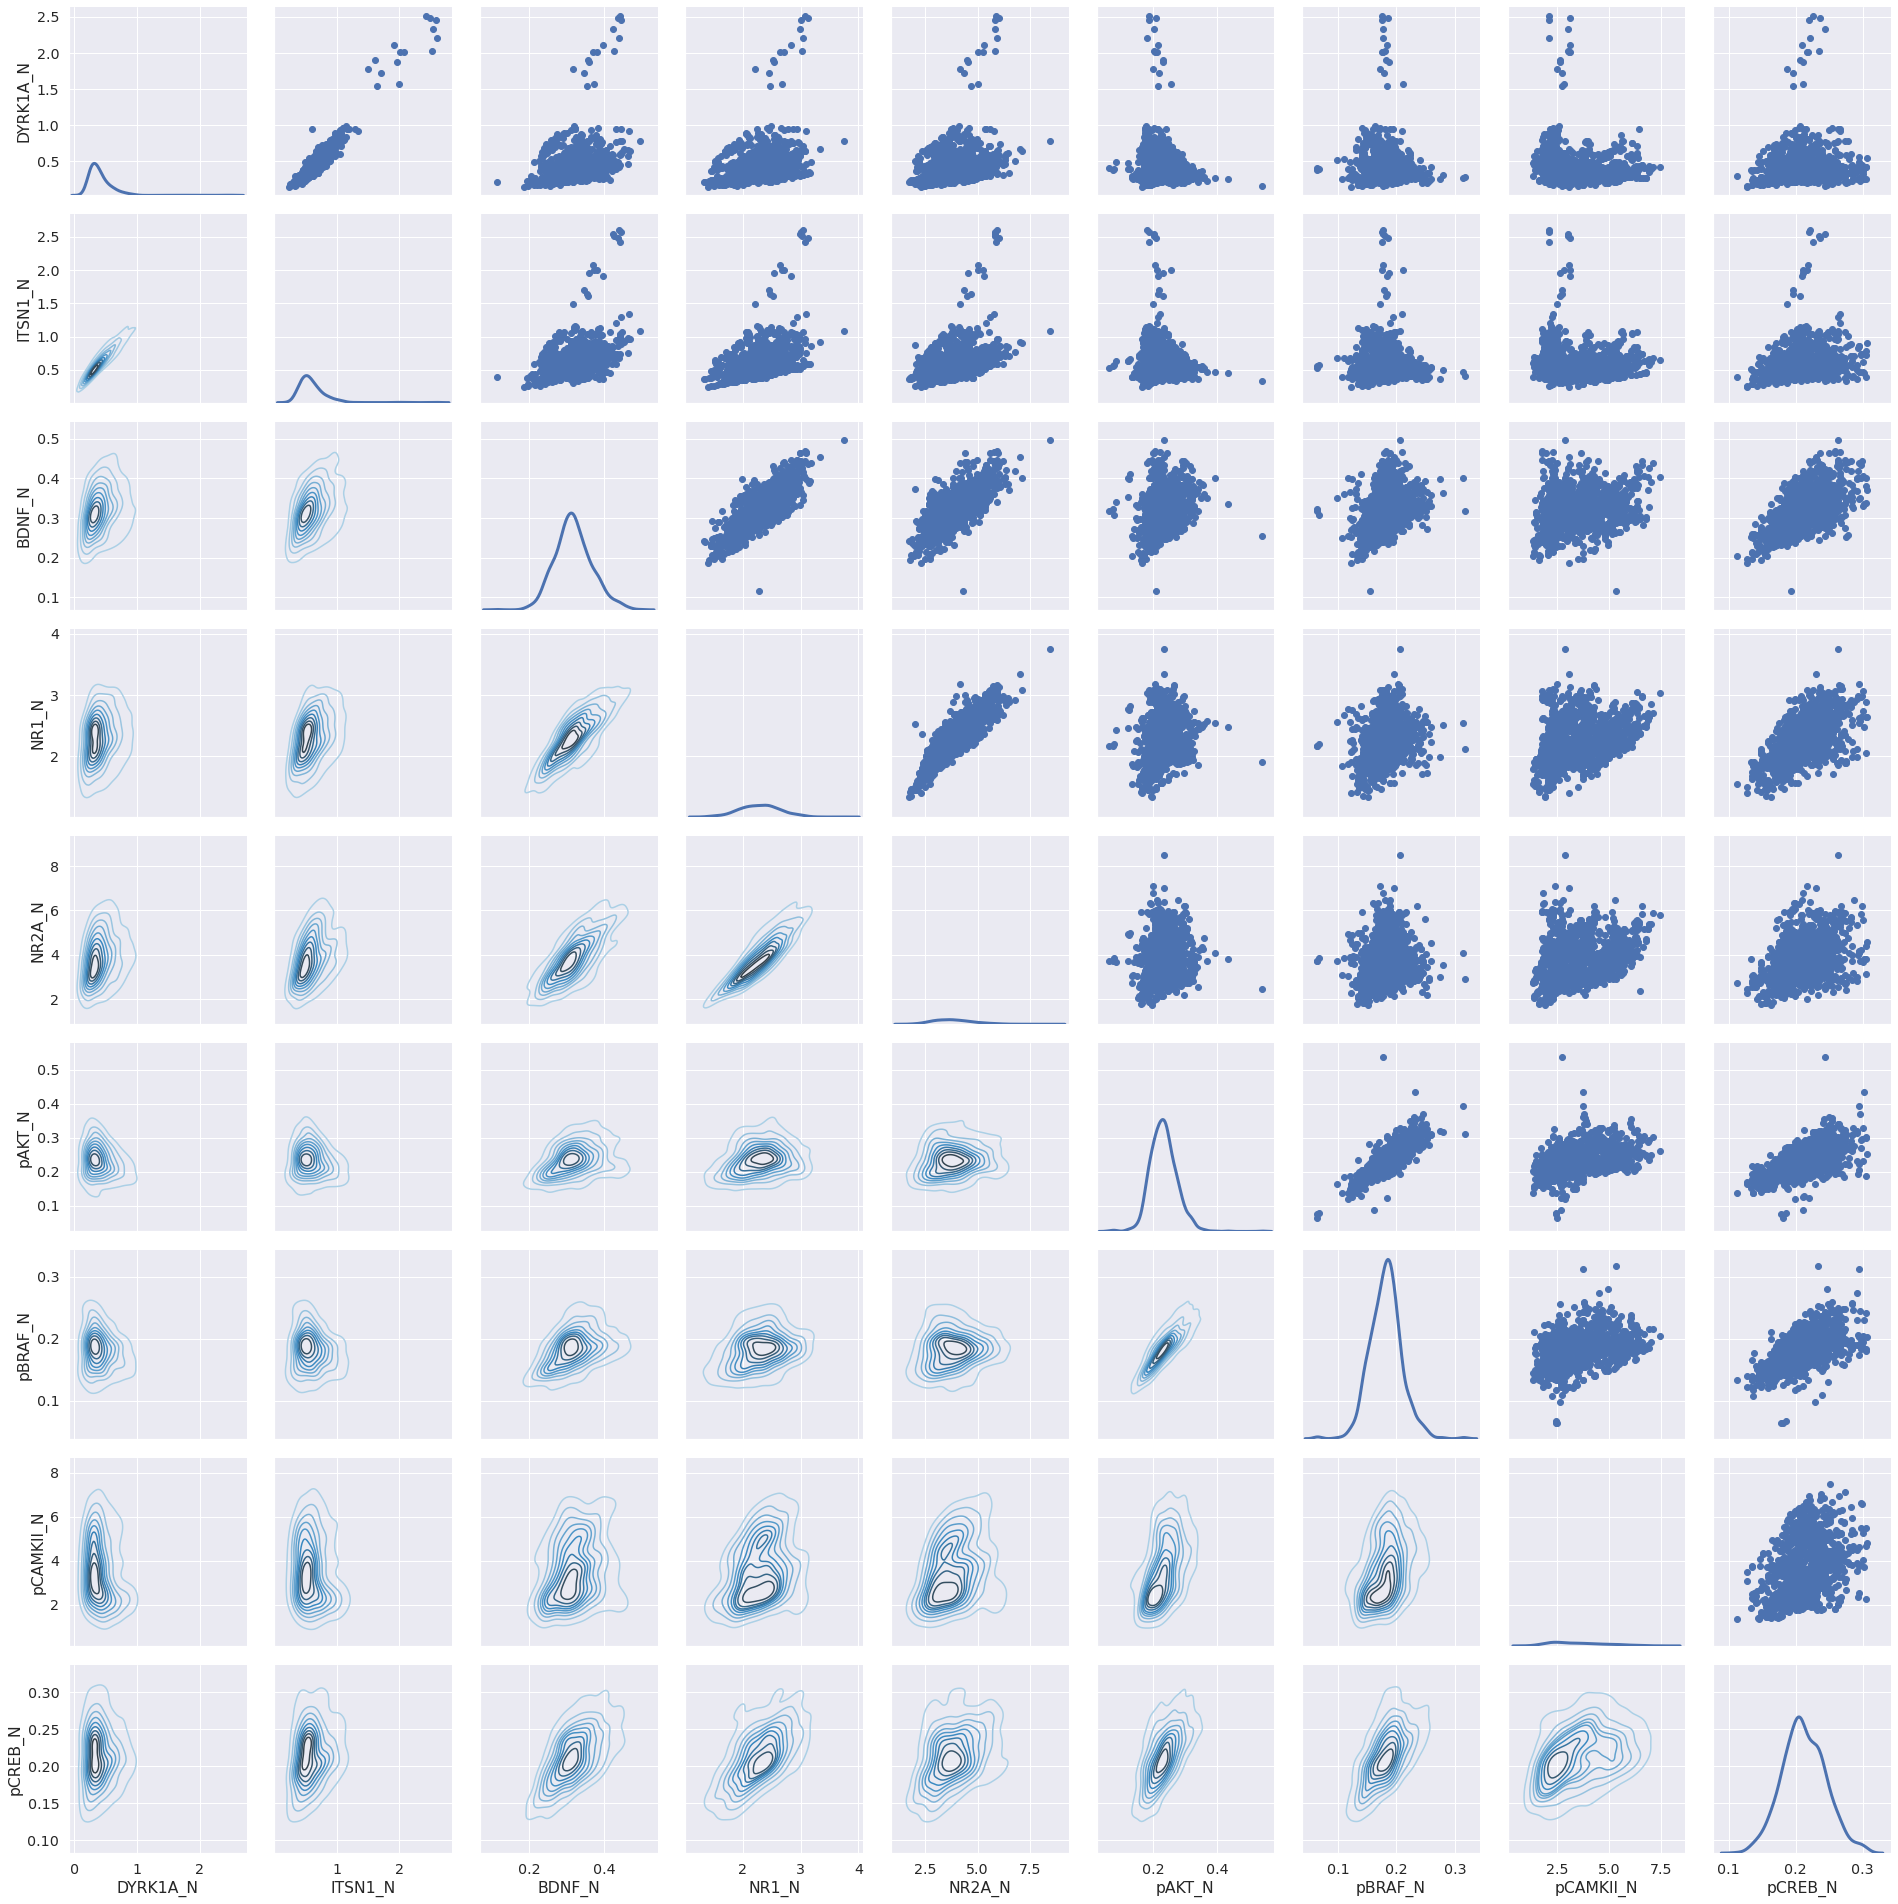

In [ ]:
g = sns.PairGrid(data.iloc[:, 1:10].dropna(), height=3)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

Визуализируйте двумерные проекции данных и ядерные оценки плотности с использованием `sns.PairGrid` отдельно по генотипам для 10 признаков. Используйте `hue='Genotype'` при вызове `sns.PairGrid`. По параметру `hue`  происходит разделение датасета.

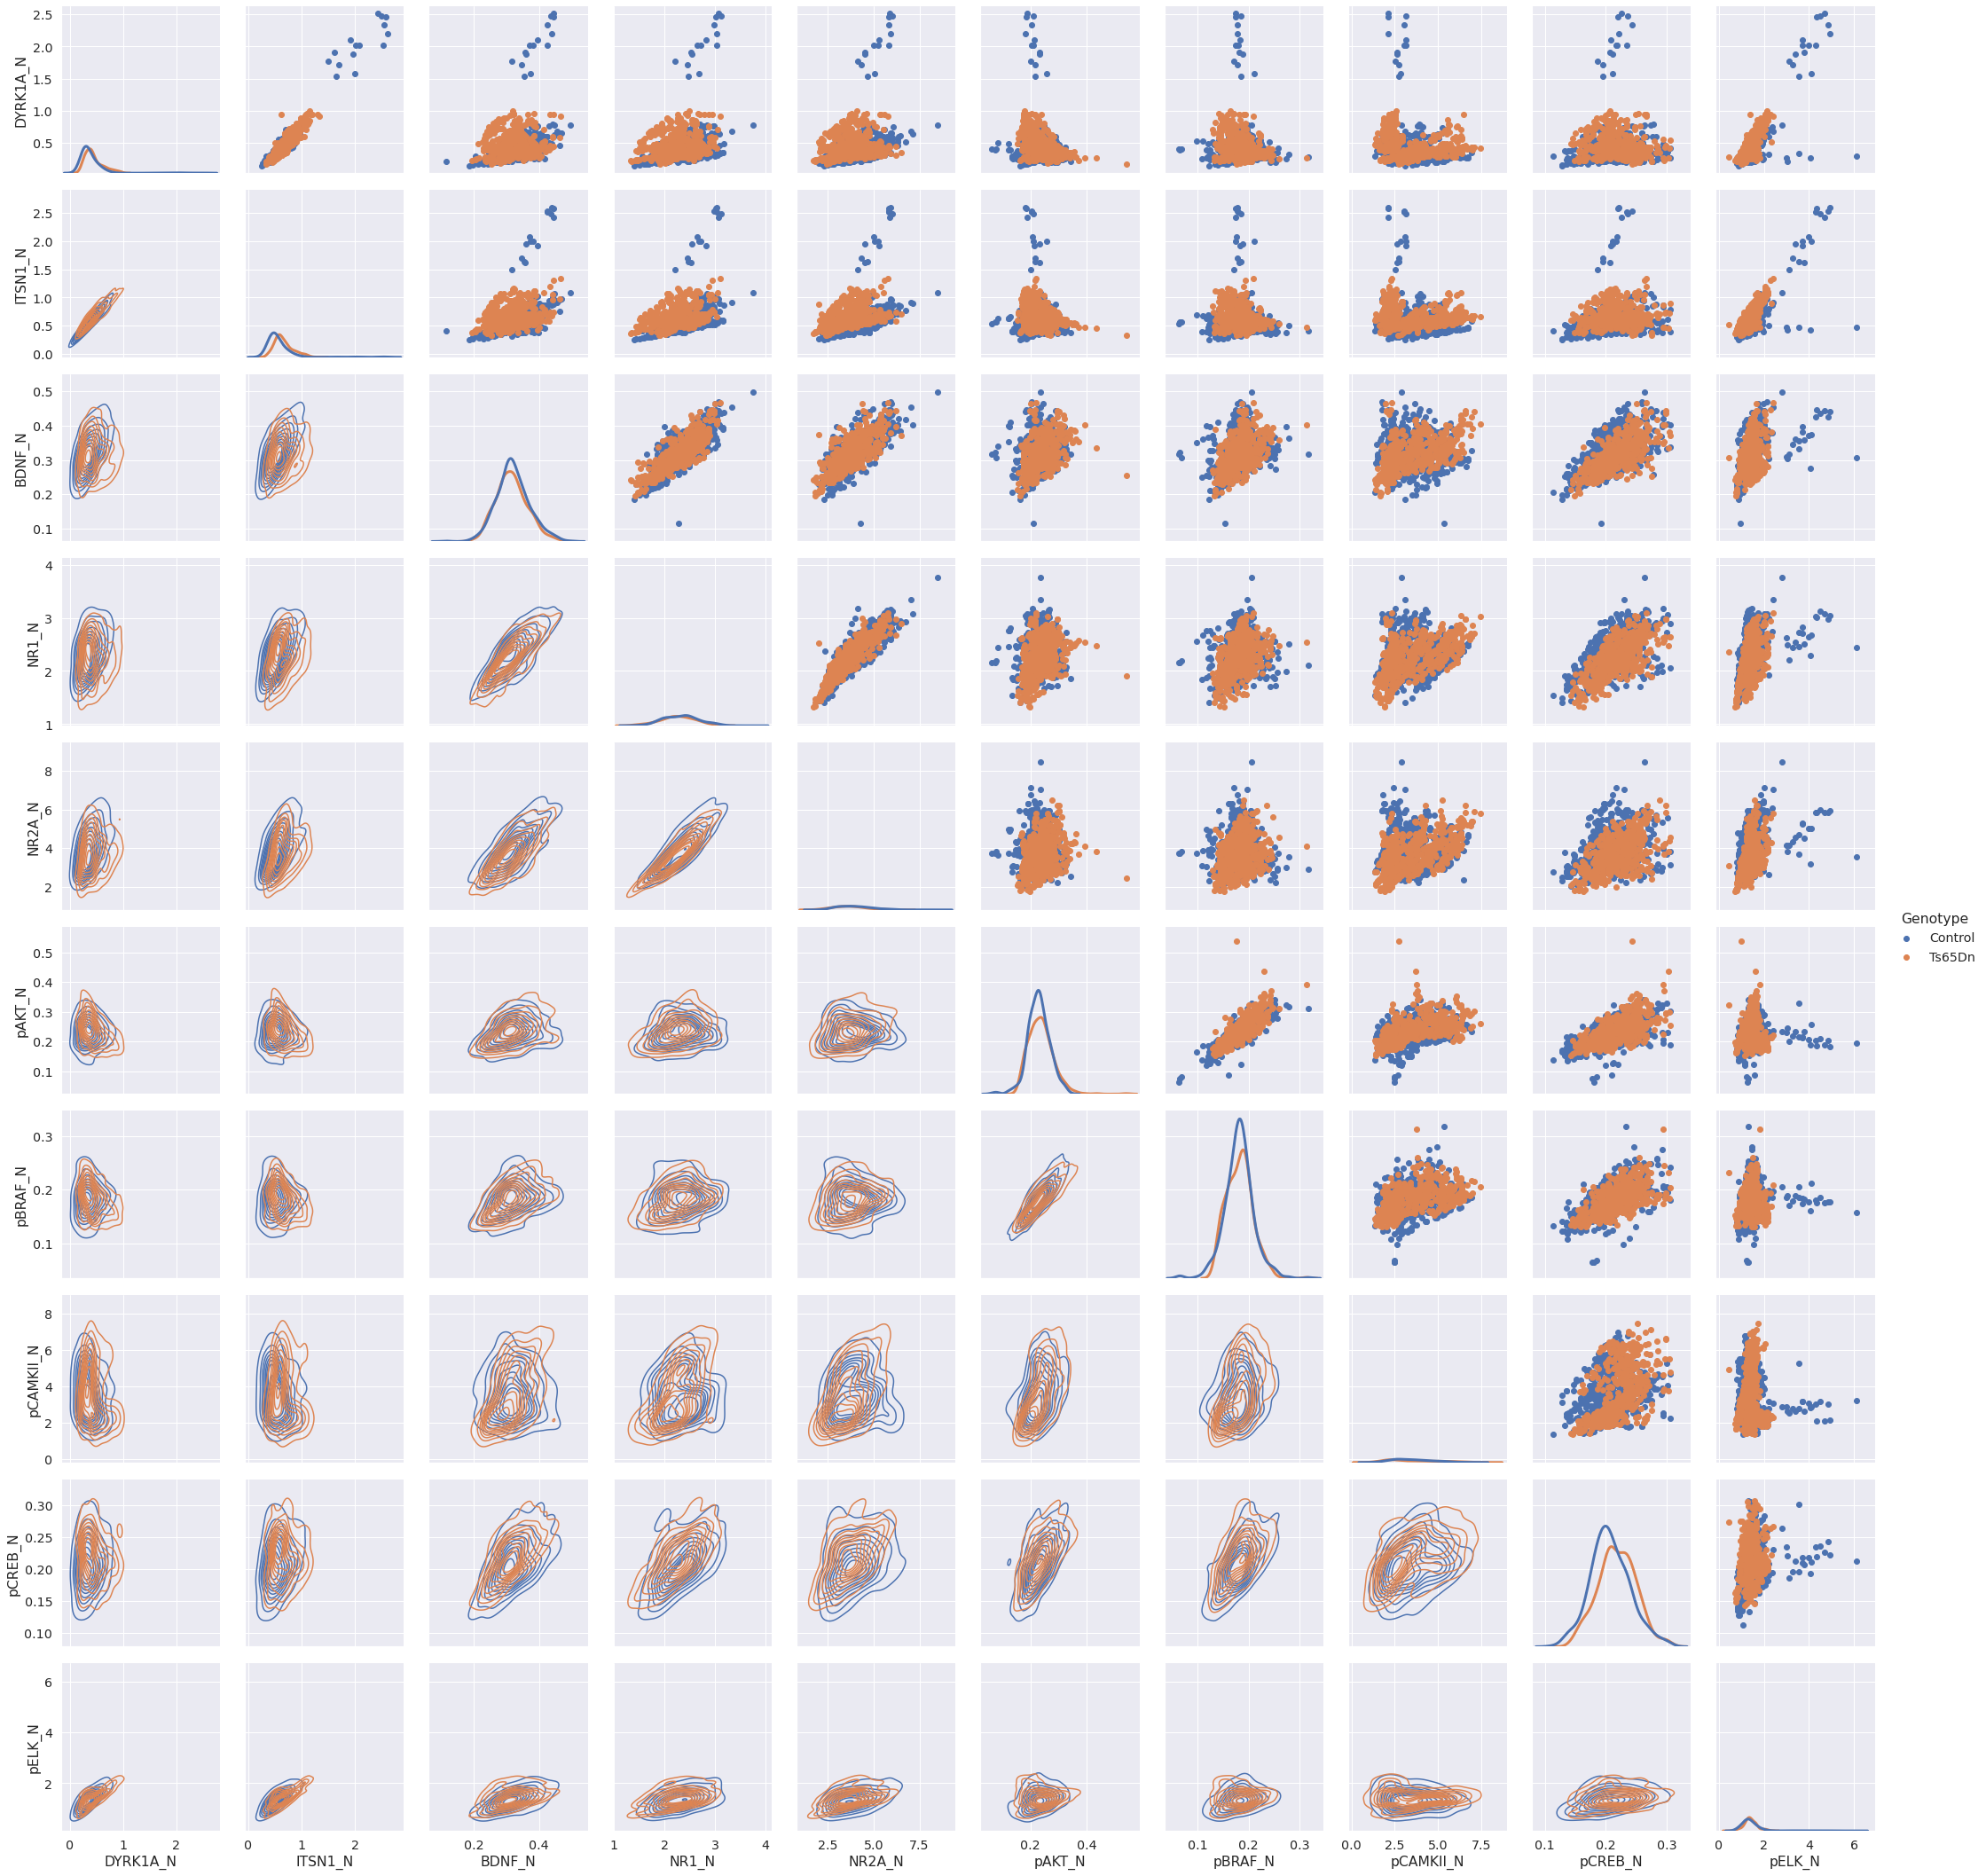

In [ ]:
g = sns.PairGrid(data[[*fav_columns[:10], 'Genotype']], height=3, hue = 'Genotype')
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)
g.add_legend()

#### 2. Дисперсионный анализ

##### 2.1. Зависимость распределения DYRK1A_N от генотипа

Проверьте гипотезу о равенстве распределений с использованием критерия Уилкоксона-Манна-Уитни с использованием различных альтернатив.  В реальных исследованиях нужно использовать конкретную альтернативу. 

Сделайте выводы. Также поясните, почему в данной задаче можно использовать этот критерий.

**Выборки независимы: генотип в течении жизни особо не меняется $⇒$ выборки независимы. Случай непараметрический.**

**$⇒$ Будем пользоваться критерием Уилкоксона-Манна-Уитни.**


**"Критерий Уилкоксона"**

**F - функция распределения экспрессии генов контрольных мышей**

**G - с генотипом Ts65Dn**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon \{F < G \text{ или } F > G\}$

**"Критерий Манна-Уитни(F<G)"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F < G$

**"Критерий Манна-Уитни(F>G)"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F > G$


In [ ]:
data_dyrk_cr = data['DYRK1A_N'][data['Genotype'] == 'Control'].dropna().to_numpy()
data_dyrk_ts = data['DYRK1A_N'][data['Genotype'] == 'Ts65Dn'].dropna().to_numpy()

p_vals = [sps.ranksums(data_dyrk_cr, data_dyrk_ts)[1], sps.mannwhitneyu(data_dyrk_cr, data_dyrk_ts, use_continuity=True, alternative='greater')[1], sps.mannwhitneyu(data_dyrk_cr, data_dyrk_ts, use_continuity=True, alternative='less')[1]]
p_vals_corr = multipletests(p_vals, method = 'holm')[1]  #МПГ
res ={}
res['по критерию Уилкоксона'], res['Манна-Уитни(F<G)'], res['Манна-Уитни(F>G)'] = p_vals_corr
pd.DataFrame(res, index=[0])

,по критерию Уилкоксона,Манна-Уитни(F<G),Манна-Уитни(F>G)
0,9.381892e-17,1.0,7.042298e-17


**Вывод**

**То есть гипотеза о одинаковом распределении неверна, на двусторонней альтернативе получили очень маленькое p-value.  Альтернатива greater, G>F, плохая - для неё p-value получилось равным единице, то есть при такой альтернативе лучше не отвергать основную гипотезу - распределения скорее равны, чем G>F. Приходим к реализации альтернативы F>G, то есть уровень экспресии гена DYRK1A_N при Ts65Dn генотипе выше чем в контроле. Что в принципе было понятно из графиков KDE этого гена для разных генотипов.**

Посчитайте реализацию оценки сдвига, связанную со статистикой Манна-Уитни, см. лекцию 11.

In [ ]:
w = np.array([])
for cr in data_dyrk_cr:
  for ts in data_dyrk_ts:
    w = np.append(w, ts - cr)
w = w[~np.isnan(w)]  #массивы разного размера => при полном переборе большего массива не хватит значений из меньшего, в итоговом массиве будут nan'ы

print(f'Оценка theta: {np.round(np.median(w),3)}')

 Оценка theta: 0.068


Посчитайте реализацию доверительного интервала величины сдвига. 


In [ ]:
n = data_dyrk_cr.shape[0]
m  = data_dyrk_ts.shape[0]
k_alfa = math.floor((n*m-1)/2  - sps.norm().ppf(0.95)*((n*m*(n+m+1)/12)**(1/2))) 
w = np.sort(w)
print(f'({np.round(w[k_alfa+1],3)}, {np.round(w[n*m - k_alfa],3)})')

(0.056, 0.082)


**Видим, что сдвиг распределений есть, он положителен, то есть F > G (что подтверждает предыдущие рассуждения). Также заметим, что в доверительный интервал значение 0 не попадает, то есть более уверены в том что гипотезу $H_0$ действительно следует отвергнуть.**

****

##### 2.2. Зависимость распределения  BDNF_N от генотипа


Проверьте гипотезу с использованием критерия Уилкоксона-Манна-Уитни при различных альтернативах, посчитайте оценку сдвига и доверительный интервал. Сделайте выводы. 

In [ ]:
data_bdnf_cr = data['BDNF_N'][data['Genotype'] == 'Control'].dropna().to_numpy()
data_bdnf_ts = data['BDNF_N'][data['Genotype'] == 'Ts65Dn'].dropna().to_numpy()

p_vals = [sps.ranksums(data_bdnf_cr, data_bdnf_ts)[1], sps.mannwhitneyu(data_bdnf_cr, data_bdnf_ts, use_continuity=True, alternative='greater')[1], sps.mannwhitneyu(data_bdnf_cr, data_bdnf_ts, use_continuity=True, alternative='less')[1]]
p_vals_corr = multipletests(p_vals, method = 'holm')[1]  #МПГ
res ={}
res['по критерию Уилкоксона'], res['Манна-Уитни(F<G)'], res['Манна-Уитни(F>G)'] = p_vals_corr
pd.DataFrame(res, index=[0])

,по критерию Уилкоксона,Манна-Уитни(F<G),Манна-Уитни(F>G)
0,0.264271,0.198241,0.933945


**То есть ни один из критериев не отвергает гипотезу о равенстве распределений, распределения скорее всего одинаковые.**

In [ ]:
w = np.array([])
for cr in data_bdnf_cr:
  for ts in data_bdnf_ts:
    w = np.append(w, ts - cr)
w = w[~np.isnan(w)] 
print(f'Оценка theta: {np.round(np.median(w),3)}')

Оценка theta: -0.004


In [ ]:
n = data_bdnf_cr.shape[0]
m  = data_bdnf_ts.shape[0]
k_alfa = math.floor((n*m-1)/2  - sps.norm().ppf(0.95)*((n*m*(n+m+1)/12)**(1/2))) 
w = np.sort(w)
print(f'({np.round(w[k_alfa+1],3)}, {np.round(w[n*m - k_alfa],3)})')

(-0.009, 0.001)


**Вывод**

**Видим, что в доверительный интервал 0 попадает, то есть вероятность того что распределения совпадают не ноль. Следовательно, в дальнейшем будем полагать что экспрессия BDNF от генотипа не зависит**

Как связаны доверительные интервалы с проверкой гипотез? Вам могут помочь прошлые лекции. Подтверждается ли это в данном примере?

**Наша гипотеза $H_0$ заключалась в том, что распределение уровня экспрессии генов от генотипа не зависит, то есть соответвующие выборки одинаково распределены. $H_1$ -  в каком-то смысле по разному. Дальше оцениваем параметр сдвига, при альтернативе доминирования, по его знаку можно понять какое из распределений статистически реализует бОльшие значения. Если его доверительный интервал включает 0, то гипотезу $H_0$ лучше не отвергать, так как доля случаев, при которых распределения не сдвинуты относительно друг друга, не 0.**

Проверьте выборку на нормальность с помощью критерия Шапиро-Уилка и QQ-plot.  Можно ли применять методы, (не)устойчивые к отклонениям от нормальности?

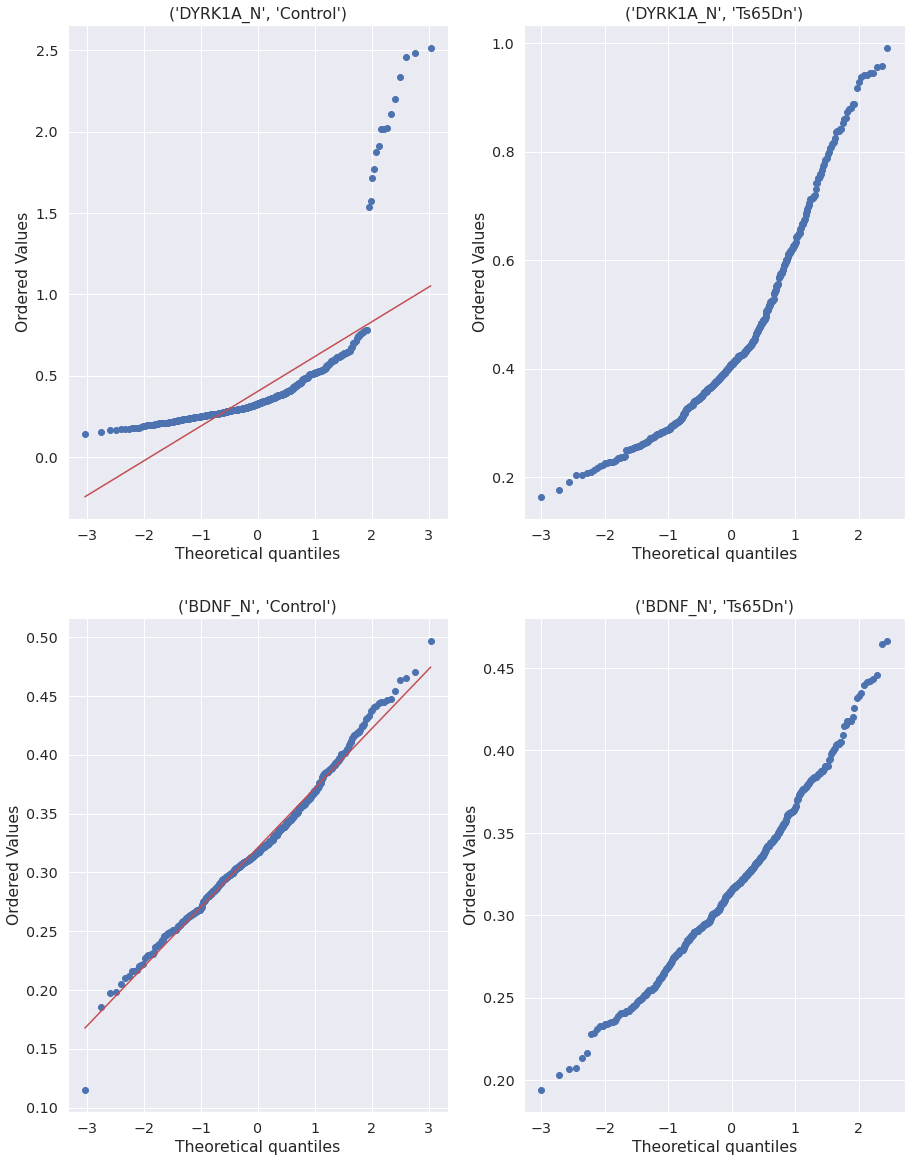

In [ ]:
plt.figure(figsize=(15,20))
count = 0
for column in ['DYRK1A_N', 'BDNF_N']:
  for genotype in ['Control', 'Ts65Dn']:
    count += 1
    ax = plt.subplot(2, 2, count)
    sps.probplot(data[column][data['Genotype'] == genotype], plot=ax)
    plt.title((column,genotype))

In [ ]:
p_vals_dyrk = [sps.shapiro(data_dyrk_cr)[1], sps.shapiro(data_dyrk_ts)[1]]
p_vals_bdnf = [sps.shapiro(data_bdnf_cr)[1], sps.shapiro(data_bdnf_ts)[1]]
res = {'p-val DYRK1A_N': p_vals_dyrk ,'МПГ DYRK': multipletests(p_vals_dyrk, method = 'holm')[1], 'p-val BDNF_N': p_vals_bdnf, 'МПГ BDNF': multipletests(p_vals_bdnf, method = 'holm')[1] }
res = pd.DataFrame(res, index = ['Control', 'Ts65Dn'])

res

,p-val DYRK1A_N,МПГ DYRK,p-val BDNF_N,МПГ BDNF
Control,5.268848e-37,1.053770e-36,0.001522,0.003044
Ts65Dn,2.185896e-16,2.185896e-16,0.006184,0.006184


**Визуально, из Q-Q плота кажется, что BDNF_N распределен нормально для обоих генотипов, а DYRK1A_N  - нет. Однако критерий Шапиро-Уилка(более жесткий) отрицает нормальность BDNF_N в обоих генотипах.**

Какой критерий можно применять в случае нормальных выборок и одинаковой дисперсии? Можно ли его применять для проверке гипотез о признаках DYRK1A_N, BDNF_N? Примените этот критерий для признака BDNF_N, сделайте выводы.

**Выборки независимы, дисперсии равны и неизвестны $⇒$ для того чтобы анализировать гипотезу** 

$X_{1}, \ldots, X_{n} \sim \mathcal{N}\left(a_{1}, \sigma_{1}^{2}\right)$

$Y_{1}, \ldots, Y_{m} \sim \mathcal{N}\left(a_{2}, \sigma_{2}^{2}\right)$

$H_{0}: a_{1}=a_{2}$

$H_{1}: a_{1}\{<, \neq,>\} a_{2}$

**надо пользоваться критерием Cтьюдента.**


---



**В даннной задаче требуется проверить эту гипотезу в пределах экспрессии одного гена(для DYRK1A_N и BDNF_N), но разных генотипов. При этом для DYRK1A_N этим критерием пльзоваться нельзя, потому что его выборки нормально не распределены. C BDNF_N всё хорошо, его дисперсии можно считать равными на основании KDE: его ширина для разных генотипов примерно одинаковая.**

In [ ]:
sps.ttest_ind(data_bdnf_cr, data_bdnf_ts, equal_var=True)

Ttest_indResult(statistic=1.440470979622491, pvalue=0.15002536864087548)

**Вывод**

**При применении к BDNF_N критерий даёт тот же результат, что и критерий Уилкоксона-Манна-Уитни, поэтому можем предположить что он не слишком чувствителен к отклонениям от нормальности.**

#### 3. Зависимость уровня экспрессии от генотипа для всех исследуемых белков

Задача заключается в том, чтобы среди всех белков отобрать для дальнейшего более подробного анализа те, по которым уровень экспрессии гена отличается по двум генотипам. Для решения задачи проверьте гипотезы об однородности по генотипам для каждого белка с использованием критерия Уилкоксона-Манна-Уитни.

Почему в данном случае стоит использовать его, а не критерий Стьюдента?

Не забудьте о множественной проверке гипотез. Заметим, что цель исследований &mdash; **отбор** признаков для дальнейшего анализа. Какой метод стоит применять в данном случае? *Обратите внимание на то, как устроены данные.*

Распечатайте результаты МПГ для всех признаков. Сделайте вывод.

**Ответы на вопросы**: 


**1. Критерий Стьюдента о нормальных распределениях, для всех белков мы этого гарантировать не можем. Критерий  Уилкоксона-Манна-Уитни также для независимых выборок, но позволяет рассмотреть непараметрический случай, работает с абстрактнами распределениями. Воспользуемся критерием Уилкоксона с двусторонней альтернативой**

**2. При первичном отборе статистически значимых признаков используется FDR, c $\alpha = 0.1$. Так как статистики могут оказаться зависимыми: экспрессия одного гена зависит от другого, будем использовать метод Бенджамини-Иекутиели, как самый мощный в таком случае.**



In [ ]:
res = {}
newline = {}
for column in fav_columns:
  res[column] = sps.ranksums(data[column][data['Genotype'] == 'Control'].dropna().to_numpy(), data[column][data['Genotype'] == 'Ts65Dn'].dropna().to_numpy())[1]

p_vals_fdr = [elem for elem in res.values()]
p_vals_fdr =  multipletests(p_vals_fdr, method = 'fdr_by', alpha = 0.1)[0]

for count, column in enumerate(fav_columns):
  newline[column]  = str(p_vals_fdr[count])

res = pd.DataFrame(res, index= [0])
res = res.append(newline, ignore_index=True)
res.index = ['p-value до МПГ', 'с FDR']
res

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
p-value до МПГ,0.0,0.0,0.132135,0.002923,0.000002,0.056534,0.867122,0.488552,0.0,0.002488,...,0.647619,0.080071,0.221761,0.0,0.018555,0.0,0.0,0.000016,0.000118,0.05962
с FDR,True,True,False,True,True,False,False,False,True,True,...,False,False,False,True,False,True,True,True,True,False


**True соответсвует случаям, для которых гипотеза об однородности неверна, уровень экспрессии гена отличается по двум генотипам.**

In [ ]:
proteins = []
for column in res.columns:
  if res[column][1] == 'True':
    proteins.append(column)
proteins

['DYRK1A_N',
 'ITSN1_N',
 'NR1_N',
 'NR2A_N',
 'pCREB_N',
 'pELK_N',
 'pNR1_N',
 'pNR2A_N',
 'pNR2B_N',
 'pRSK_N',
 'AKT_N',
 'BRAF_N',
 'CAMKII_N',
 'GSK3B_N',
 'TRKA_N',
 'APP_N',
 'MTOR_N',
 'P38_N',
 'pMTOR_N',
 'DSCR1_N',
 'AMPKA_N',
 'NR2B_N',
 'RAPTOR_N',
 'TIAM1_N',
 'pP70S6_N',
 'NUMB_N',
 'pGSK3B_N',
 'pPKCG_N',
 'CDK5_N',
 'S6_N',
 'ADARB1_N',
 'AcetylH3K9_N',
 'RRP1_N',
 'ARC_N',
 'Tau_N',
 'GluR3_N',
 'IL1B_N',
 'P3525_N',
 'SNCA_N',
 'pGSK3B_Tyr216_N',
 'pS6_N',
 'SYP_N',
 'H3AcK18_N',
 'EGR1_N',
 'H3MeK4_N']

In [ ]:
exept = [z for z in fav_columns if not z in proteins]  #имена тех для которых гипотеза об однородности скорее всего верна
exept   

['BDNF_N',
 'pAKT_N',
 'pBRAF_N',
 'pCAMKII_N',
 'pERK_N',
 'pJNK_N',
 'PKCA_N',
 'pMEK_N',
 'pPKCAB_N',
 'CREB_N',
 'ELK_N',
 'ERK_N',
 'JNK_N',
 'MEK_N',
 'RSK_N',
 'Bcatenin_N',
 'SOD1_N',
 'pNUMB_N',
 'P70S6_N',
 'BAX_N',
 'ERBB4_N',
 'nNOS_N',
 'GFAP_N',
 'GluR4_N',
 'pCASP9_N',
 'PSD95_N',
 'Ubiquitin_N',
 'SHH_N',
 'BAD_N',
 'BCL2_N',
 'pCFOS_N',
 'CaNA_N']

Для каждого признака посчитайте оценку сдвига. Сделайте вывод.

In [136]:
thetas = {}
w ={}
for name in tqdm(fav_columns):
  extra = np.array([])
  for cr in data[name][data['Genotype'] == 'Control'].dropna().to_numpy():
    for ts in data[name][data['Genotype'] == 'Ts65Dn'].dropna().to_numpy():
       extra = np.append(extra, ts - cr)
  extra = extra[~np.isnan(extra)]
  w[name] =np.sort(extra) 
  thetas[name] = np.round(np.median(extra),3)

pd.DataFrame(thetas, index = [0])

  0%|          | 0/77 [00:00<?, ?it/s]

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,0.068,0.114,-0.004,-0.065,-0.269,0.005,0.0,-0.054,0.012,0.052,...,-0.001,0.003,-0.002,-0.005,-0.003,-0.032,0.019,-0.01,0.014,0.038


In [139]:
interval =[]
for name in fav_columns:
  n = data[name][data['Genotype'] == 'Control'].dropna().to_numpy().shape[0]
  m  = data[name][data['Genotype'] == 'Ts65Dn'].dropna().to_numpy().shape[0]
  k_alfa = math.floor((n*m-1)/2  - sps.norm().ppf(0.95)*((n*m*(n+m+1)/12)**(1/2)))
  if w[name][k_alfa+1] <= 0 <= w[name][n*m - k_alfa]:
    interval.append(name)
    
interval

['BDNF_N',
 'pBRAF_N',
 'pCAMKII_N',
 'pJNK_N',
 'PKCA_N',
 'pMEK_N',
 'pPKCAB_N',
 'ELK_N',
 'JNK_N',
 'RSK_N',
 'Bcatenin_N',
 'SOD1_N',
 'pNUMB_N',
 'P70S6_N',
 'BAX_N',
 'ERBB4_N',
 'nNOS_N',
 'GFAP_N',
 'GluR4_N',
 'pCASP9_N',
 'PSD95_N',
 'Ubiquitin_N',
 'SHH_N',
 'BCL2_N']

**Вывод**

**Чем больше по модулю оцениваемый сдвиг, тем больше меняется уровень экспрессии соотвествующего гена, но что то более конкретное по поводу равенства распределений сможем сказать по тому включает ли доверительный интервал в себя 0 или нет.**

**Как видим, списки генов полученные двумя разными способами отличаютя слабо**


### Задача 2
Для анализа будем использоваться датасет <a href="https://ru.wikipedia.org/wiki/Экспрессия_генов">экспресии генов</a> в нормальных тканях и в <a href="https://ru.wikipedia.org/wiki/Карцинома">карциномах</a>, полученные c помощью нуклеотидных [микрочипов](https://ru.wikipedia.org/wiki/%D0%94%D0%9D%D0%9A-%D0%BC%D0%B8%D0%BA%D1%80%D0%BE%D1%87%D0%B8%D0%BF). Данные опубликованы в работе `Notterman, et al, Cancer Research vol. 61: 2001`.
Всего доступна информация о 18 опухолевых образцах и о соответсвующих им здоровых тканях.

Для лучшего понимания задачи можно почитать следующие статьи:
* https://fb.ru/article/256575/ekspressiya-genov---eto-chto-takoe-opredelenie-ponyatiya
* https://ru.qwe.wiki/wiki/Gene_expression

Загрузим данные

In [ ]:
! wget http://genomics-pubs.princeton.edu/oncology/Data/CarcinomaNormalDatasetCancerResearchText.zip
! unzip CarcinomaNormalDatasetCancerResearchText.zip

--2022-05-01 14:29:57--  http://genomics-pubs.princeton.edu/oncology/Data/CarcinomaNormalDatasetCancerResearchText.zip
Resolving genomics-pubs.princeton.edu (genomics-pubs.princeton.edu)... 128.112.102.64
Connecting to genomics-pubs.princeton.edu (genomics-pubs.princeton.edu)|128.112.102.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549752 (537K) [application/zip]
Saving to: ‘CarcinomaNormalDatasetCancerResearchText.zip’

CarcinomaNormalData 100%[===================>] 536.87K  --.-KB/s    in 0.1s    

2022-05-01 14:29:57 (4.78 MB/s) - ‘CarcinomaNormalDatasetCancerResearchText.zip’ saved [549752/549752]

Archive:  CarcinomaNormalDatasetCancerResearchText.zip
  inflating: CarcinomaNormalDatasetCancerResearch.txt  


Загрузим данные в `pandas` и посмотрим на них:

In [142]:
data = pd.read_table(
    "CarcinomaNormalDatasetCancerResearch.txt", 
    skiprows=range(1,8), index_col=0, usecols=range(39)
)
data = data.drop(['Sample'], axis=1)

data.head()

,Description,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
X53416,Human mRNA for actin-binding protein (filamin)...,70.0,108.0,75.0,871.0,-92.0,21.0,225.0,-346.0,-378.0,...,632.0,1412.0,1122.0,644.0,1760.0,488.0,164.0,1282.0,68.0,928.0
M83670,"""Human carbonic anhydrase IV mRNA, complete cds""",-81.0,-30.0,-1.0,4.0,-34.0,-13.0,118.0,-35.0,31.0,...,185.0,288.0,416.0,625.0,320.0,564.0,330.0,116.0,718.0,332.0
X90908,H.sapiens mRNA for I-15P (I-BABP) protein,25.0,-7.0,5.0,14.0,14.0,5.0,-5.0,37.0,-29.0,...,4723.0,-21.0,-7.0,-28.0,-8.0,-29.0,-13.0,-4.0,-50.0,4.0
M97496,"""Homo sapiens guanylin mRNA, complete cds""",10.0,60.0,48.0,78.0,19.0,11.0,175.0,42.0,105.0,...,1107.0,731.0,1559.0,1762.0,917.0,1303.0,721.0,542.0,1816.0,412.0
X90908,H.sapiens mRNA for I-15P (I-BABP) protein,22.0,0.0,6.0,-6.0,11.0,-18.0,-40.0,39.0,-54.0,...,3344.0,8.0,5.0,-7.0,-2.0,-9.0,12.0,0.0,-28.0,0.0


Посмотрим также на хвост данных

In [ ]:
data.tail()

,Description,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
X54489,Human gene for melanoma growth stimulatory act...,123.0,271.0,127.0,59.0,265.0,3.0,110.0,30.0,97.0,...,3.0,8.0,16.0,8.0,19.0,11.0,3.0,7.0,21.0,32.0
T55008,yb45h04.s1 Homo sapiens cDNA clone 74167 3' si...,2.0,-1.0,7.0,3.0,-2.0,9.0,7.0,-5.0,0.0,...,-4.0,-5.0,-17.0,15.0,-10.0,7.0,-5.0,3.0,22.0,-5.0
M10065,"""Human apolipoprotein E (epsilon-4 allele) gen...",19.0,-51.0,192.0,367.0,126.0,145.0,-14.0,-53.0,-51.0,...,-103.0,39.0,-10.0,-97.0,-1.0,-145.0,-63.0,-69.0,-214.0,72.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В конце прочитались две пустых строки. Удалим их и убедимся, что пропусков в данных нет

In [146]:
data = data.iloc[:-2]
data.isna().sum()

Description    1
Tumor 27       0
Tumor 29       0
Tumor 34       0
Tumor 28       0
Tumor 35       0
Tumor 8        0
Tumor 3        0
Tumor 9        0
Tumor 4        0
Tumor 32       0
Tumor 39       0
Tumor 10       0
Tumor 33       0
Tumor 5        0
Tumor 11       0
Tumor 6        0
Tumor 12       0
Tumor 40       0
Normal 27      0
Normal 29      0
Normal 34      0
Normal 28      0
Normal 35      0
Normal 8       0
Normal 3       0
Normal 9       0
Normal 4       0
Normal 32      0
Normal 39      0
Normal 10      0
Normal 33      0
Normal 5       0
Normal 11      0
Normal 6       0
Normal 12      0
Normal 40      0
dtype: int64

Каждый ряд соответствует какому-то из интересующих нас генов, а колонка соответствует данным об экспресии каждого гена в опухолевых (`Tumor`) и контрольных (`Normal`) клеток.

Явно укажем вещественный тип данных

In [147]:
data.iloc[:, 2:] = data.iloc[:, 2:].astype('float')

Проверим, уникальны ли все образцы в датасете, для этого сравним количество уникальных ID генов с количеством строк:

In [148]:
len(np.unique(data.index)), len(data.index)

(6604, 7464)

Некоторые эксперименты повторялись более одного раза. Оставим те, где средний уровень экспрессии выше.

In [150]:
data['mean_expr'] = data.iloc[:, 1:-1].mean(axis=1)
data.sort_values(by=['mean_expr'], ascending=False)
data = data.groupby('Accession Number').first()

Сохраним описания генов и данные по их экспрессии отдельно. Значение средней экспрессии нам не нужны, поэтому избавимся от них

In [151]:
expr_data, descr = data.drop(
    ['Description', 'mean_expr'], axis=1
), data.Description

In [152]:
expr_data.head()

,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,Tumor 32,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
BioB,-2.0,-11.0,-17.0,-1.0,-14.0,-8.0,-13.0,31.0,-24.0,-17.0,...,-23.0,-10.0,-13.0,-25.0,-12.0,-10.0,3.0,-3.0,-24.0,-14.0
BioC,12.0,9.0,17.0,18.0,10.0,53.0,-2.0,57.0,-15.0,54.0,...,-16.0,13.0,14.0,-10.0,14.0,-18.0,75.0,-20.0,22.0,3.0
BioD,107.0,65.0,108.0,95.0,94.0,473.0,93.0,161.0,60.0,232.0,...,58.0,104.0,117.0,142.0,123.0,207.0,461.0,137.0,289.0,82.0
D00003,2.0,7.0,1.0,-3.0,0.0,10.0,15.0,-2.0,36.0,-1.0,...,626.0,0.0,0.0,74.0,4.0,13.0,24.0,4.0,4.0,-1.0
D00015,26.0,13.0,13.0,9.0,2.0,10.0,20.0,17.0,21.0,17.0,...,24.0,79.0,22.0,52.0,59.0,40.0,42.0,71.0,43.0,60.0


Для удобства работы транспонируем матрицу данных об экспрессии, и разметим для каждой строки, является ли образец опухолевым или нормой

In [153]:
expr_data = expr_data.T

Осуществим разметку данных

In [154]:
expr_data['Label'] = expr_data.index.map(
    lambda x: 'Tumor' if x.split(' ')[0] == 'Tumor' else 'Normal'
)
#у раковых был Label = -1, у нормальных = 1, переделала на читаемые, чтобы плот'ы были понятнее
expr_data.head()


Accession Number,BioB,BioC,BioD,D00003,D00015,D00102,D00137,D00173,D00265,D00306,...,Z50753,Z50788,b-actin-3,b-actin-5,b-actin-M,cre,gapdh-3,gapdh-5,gapdh-M,Label
Tumor 27,-2.0,12.0,107.0,2.0,26.0,5.0,18.0,1.0,153.0,-7.0,...,35.0,-1.0,797.0,559.0,849.0,246.0,1214.0,676.0,873.0,Tumor
Tumor 29,-11.0,9.0,65.0,7.0,13.0,2.0,13.0,5.0,145.0,-7.0,...,26.0,3.0,1298.0,409.0,1093.0,414.0,1394.0,477.0,609.0,Tumor
Tumor 34,-17.0,17.0,108.0,1.0,13.0,0.0,11.0,10.0,132.0,-6.0,...,25.0,1.0,862.0,667.0,961.0,449.0,1252.0,635.0,754.0,Tumor
Tumor 28,-1.0,18.0,95.0,-3.0,9.0,10.0,28.0,8.0,73.0,-17.0,...,41.0,-2.0,1047.0,643.0,1100.0,369.0,1313.0,785.0,1013.0,Tumor
Tumor 35,-14.0,10.0,94.0,0.0,2.0,-5.0,6.0,10.0,184.0,10.0,...,29.0,2.0,1253.0,437.0,844.0,345.0,1292.0,497.0,669.0,Tumor


Посмотрим на значения экспрессии случайного гена и сравним плотности этих распределений.

Выберите ген `D00137`  и постройте на одном графике ядерные оценки плотности экспрессии в нормальных и раковых тканях (две оценки).

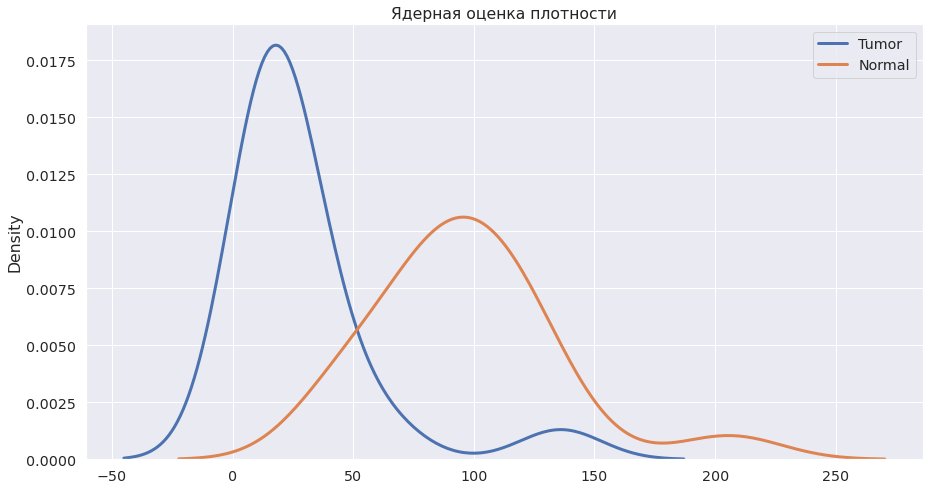

In [155]:
tum = expr_data['D00137'][expr_data['Label'] == 'Tumor'].to_numpy()
norm = expr_data['D00137'][expr_data['Label'] == 'Normal'].to_numpy()

plt.figure(figsize=(15, 8))
plt.title("Ядерная оценка плотности")
sns.kdeplot(tum, lw=3, label="Tumor")
sns.kdeplot(norm, lw=3, label="Normal")
plt.legend()
plt.show()

В анализе данных также часто применяется простой визуальный метод сравнения распределений: boxplot или ящик с усами.  На  графике ящика с усами в наглядном виде указана медиана выборки, выборочные квантили уровня 25% и 75%, а также потенциальные выбросы:


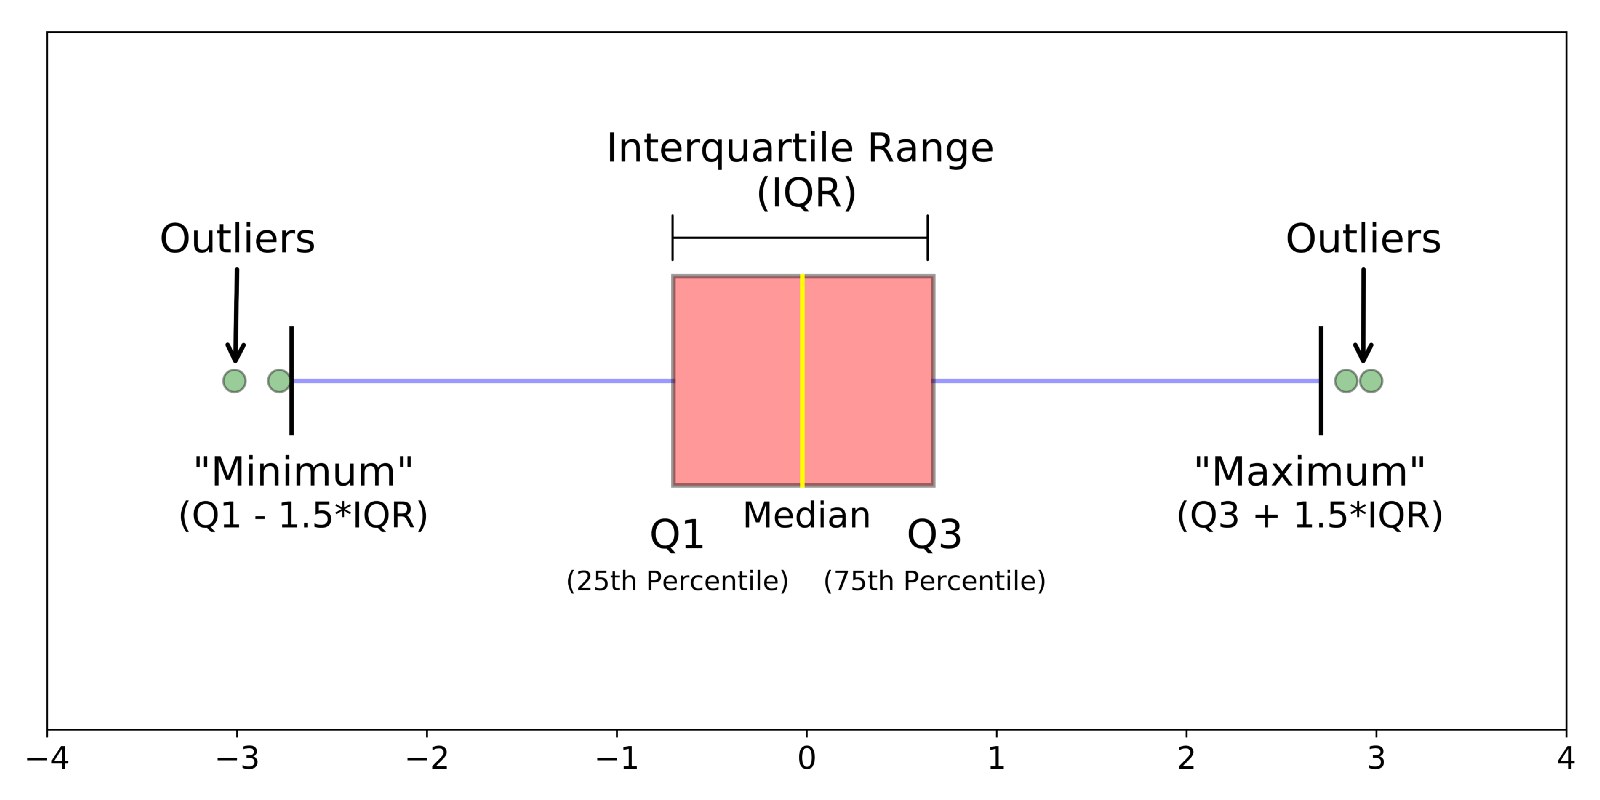

Постройте ящик с усами для гена `D00137`   , так чтобы по оси x был параметр `Label`, а по оси y &mdash; значения экспрессии, т.е. свой ящик для нормальной и раковой тканей. Используйте функцию `sns.boxplot`.

In [156]:
df_D00137 = pd.concat([expr_data[expr_data.Label== 'Normal'].loc[:, ['D00137', 'Label']], 
                     expr_data[expr_data.Label== 'Tumor'].loc[:, ['D00137', 'Label']]])


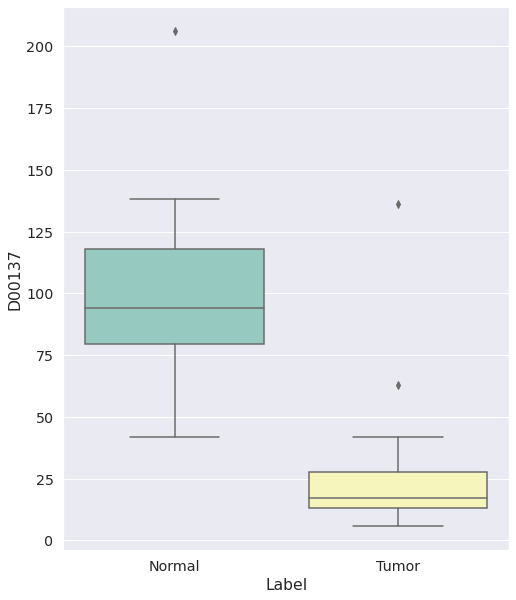

In [157]:
plt.figure(figsize=(8,10))
ax = sns.boxplot(x="Label", y ='D00137', data=df_D00137, palette="Set3")

Постройте аналогичные графики, используя `seaborn.violinplot` , популярную модификацию boxplot-а.

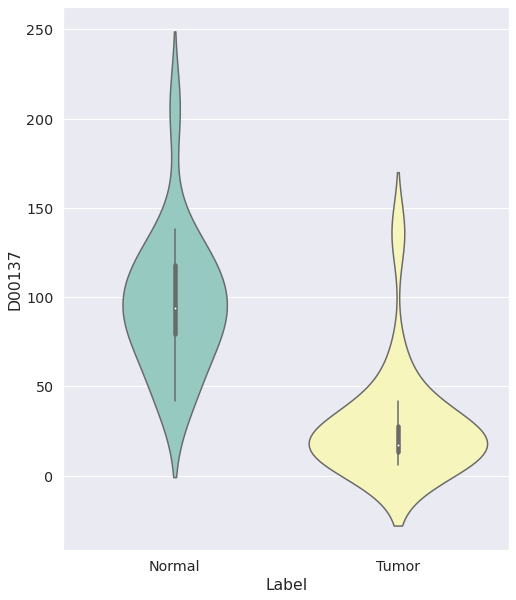

In [ ]:
plt.figure(figsize=(8,10))
gx = sns.violinplot(x="Label", y ='D00137', data=df_D00137, palette="Set3", plot = plt.subplot(1, 2, 2))

Как устроен violinplot ? Какой способ визуализации кажется вам более информативным? Почему?

**Violinplot выглядит как совмещение boxplot'a и KDE, визуально элегантнее и информация не потеряна: также показана медиана данных, квантили, границы усов. В нашем случае выбросов немного и разницы особой не видно, думаю при большем количестве выбросов violinplot пользоваться удобнее чем boxplot'ом, так как видна густота этих точек. Violinpolot'ами в принципе стоит пользоваться при больших размерах выборки, скрипки для относительно небольших выборок могут выглядеть обманчиво гладкими.** 

**Мне больше нравится boxplot, так как размытия violinplot'a делают данные менее интрепретируемыми.**

На графиках видно, что для одного случайного гена профили экспрессии возможно различаются.  
Но насколько это статистически достоверно и такова ли эта картина в целом?   
  
  
Для продолжения анализа необходимо понять, как именно были получены данные. Для этого обратимся к статье:  
_Gene intensity information was converted to a mean intensity for each gene by proprietary software (Affymetrix), which includes routines for filtering and centering the data (in these experiments, to 50 intensity units). Expression of genes related to smooth muscle and connective tissue was consistently greater in the normal than the tumor samples, probably because of the greater heterogeneity of tissue type in the normal samples_

Видим, что нормализация данных уже выполнена.
Во многих случаях для визуализации удобно переходить к логарифмическому формату данных.

Предварительный зрительный анализ может сказать очень многое о том, как устроены наши данные. Тем не менее, для получения полной картины простого взгляда на данные недостаточно. Первое на что нужно обрать внимание &mdash; это параметры распределения. Все распределения в первую очередь характеризуются медианой и средним. Для гена `D00137` вычислите медиану и средний уровень экспрессии в опухолевых и нормальных тканей.

In [158]:
data_137_tum = df_D00137['D00137'][df_D00137.Label == 'Tumor'].to_numpy()
data_137_norm = df_D00137['D00137'][df_D00137.Label == 'Normal'].to_numpy()
res = {}
res['means'] = np.round([np.mean(data_137_tum), np.mean(data_137_norm)],2)
res['medians'] = [np.median(data_137_tum), np.median(data_137_norm)]
res = pd.DataFrame(res, index = ('Tumor','Normal'))
res

,means,medians
Tumor,28.17,17.0
Normal,97.00,94.0


Для того, чтобы утверждать, что "ген `X` овер-экспрессирован в опухолевых образцах", недостаточно просто посмотреть на боксплоты, необходимо провести статистический анализ.

Для анализ одного гена проверяются гипотезы о сравнении профилей экспрессий между опухолевыми и контрольными образцами:  
   $\mathsf{H}_0\colon$ для гена `X` не наблюдается разницы средних экспрессий;  
   $\mathsf{H}_1\colon$ для гена `X` наблюдается разница средних экспрессий.
    
Какой критерий стоит выбрать для проверки в предположении нормальности распределений? Воспользуйтесь этим критерием для проверки гипотезы для гена `Human class I alcohol dehydrogenase beta-1 subunit, allele 1 mRNA, complete cds` (см. столбец `Description`).

In [161]:
data[data['Description']=='"Human class I alcohol dehydrogenase beta-1 subunit, allele 1 mRNA, complete cds"']

,Description,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,...,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40,mean_expr
Accession Number,,,,,,,,,,,,,,,,,,,,,
D00137,"""Human class I alcohol dehydrogenase beta-1 su...",18.0,13.0,11.0,28.0,6.0,63.0,26.0,136.0,26.0,...,138.0,118.0,92.0,96.0,50.0,85.0,79.0,81.0,206.0,62.583333


**То есть это и есть рассматриваемый раннее ген, у него по KDE кажется что дисперсии для разных выборок отличаются, на всякий проверим критерием Барлетта:**

$\mathsf{H}_0\colon \sigma_1 = ... = \sigma_k$


In [164]:
sigma = sps.bartlett(data_137_tum, data_137_norm)[1]  
sigma

0.35004510955372914

$⇒$ **Можем пользоваться F - критерием:**

$H_0: \mu_1 = \mu_2, \quad \mu_j -$ **средний уровень экспрессии в j-м случае**

**P.S. Если бы дисперсии были разные, то стоило бы воспользоваться критерем Аспина - Уэлша**

In [245]:
srednee = sps.f_oneway(data_137_tum, data_137_norm)[1]
multipletests([sigma, srednee], method = 'holm')[0][1]

True

Проинтерпретируйте результаты:

**Для гена D00137 наблюдается разница средних экспрессий, то что распределения сильно отличаются было понятно по средним и медианам**

Давайте проверим, что наши данные действительно разделяются на два разных распределения. Для этого проверим, как будет работать этот же метод, если случайным образом перемешать метки подгрупп. Реализуйте случайное сэмплирование с помощью функции `random.choice` из библиотеки `numpy` и посмотрите, как изменится p-value (и изменится ли).

In [185]:
data_137 = df_D00137['D00137'].to_numpy()
random_tum = np.random.choice(data_137, size = data_137_tum.shape[0], replace = False)
random_norm = np.random.choice(data_137,  size = data_137_norm.shape[0], replace = False)
multipletests([sigma, srednee, sps.f_oneway(random_tum, random_norm)[1]], method = 'holm')[0][2]

False

Сделайте вывод

**То есть при случайном выборе данных нужных размеров получаем, что гипотеза о равенстве средних не отвергается. То есть наши данные изначально разделяются на разные распределения в зависимости от генотипа.**

И, наконец, самое интересное. Посчитайте, в каком проценте генов, для которых с уровнем значимости 0.05 наблюдается овер-экспрессия в опухолевых тканях. При этом важно выполнить поправку на множественное тестирование.

Сначала выполним несколько учебных заданий. 

а*) Реализуйте критерий, который вы использовали в предыдущем пункте, самостоятельно. 

**F - критерий имеет вид**

$S = \{F(x) > F_{k-1, N-k, 1-\alpha}\}, k = 2$

In [8]:
def F_criter(data1, data2, alfa = 0.05):
  """Выдает значение F(x), критическое значение F-критерия, попадание в критическое 
  множество для случая двух выборок. Если True, то отвергаем H_0"""
  N = data1.shape[0] + data2.shape[0]
  x = np.sum(np.hstack([data1, data2]))/N
  x1 = np.mean(data1)
  x2 = np.mean(data2)
  v_in =np.sum((data1 - x1)**2) + np.sum((data2 - x2)**2)
  v_out = data1.shape[0]*(x1 - x)**2 + data2.shape[0]*(x2 - x)**2
  F = v_out * (N - 2)/ v_in
  F_alfa = sps.f(dfn = 1, dfd = N-2).ppf(1 - alfa)
  p_val = sps.f(dfn = 1, dfd = N-2).sf(F)
  return [F > F_alfa, p_val]


б) Реализуйте поправку Бонферрони (метод Бонферрони) самостоятельно. Функция должна возвращать результаты отвержения гипотез и скорректированные p-value.

In [9]:
def bonf(p_vals, alfa = 0.05):
  """ Если True, то H_0 стоит отвергнуть"""
  p_vals = np.array(p_vals)
  m = p_vals.shape[0]
  p_corr = np.array([np.amin([1, el]) for el in m * p_vals])
  return [p_corr < alfa, p_corr]

в) Проведите МПГ с использованием вашей реализации и с использованием реализации критерия из scipy и МПГ из statsmodels. В случае, если вы не выполняли пункт а), используйте только вашу реализацию пункта б). Сравните результаты.

In [293]:
p_vals_st =np.array([])
p_vals_my = np.array([])
n = expr_data.columns[:-1].shape[0]
for name in tqdm(expr_data.columns[:-1]):
  tum = expr_data[name][:18].to_numpy()
  norm = expr_data[name][18:].to_numpy()
  p_vals_st = np.append(p_vals_st, sps.f_oneway(tum, norm)[1])
  p_vals_my = np.append(p_vals_my, F_criter(tum, norm)[1])
p_st_corr =  multipletests(p_vals_st, method = 'bonferroni')[1]
p_my_corr = bonf(p_vals_my)[1]
percent_st = p_st_corr[p_st_corr<=0.05].shape[0]/n
percent_my = p_my_corr[p_my_corr<=0.05].shape[0]/n
print(np.round([percent_st, percent_my],3))

  0%|          | 0/6604 [00:00<?, ?it/s]

[0.022 0.022]


**Заметим, что значения получились одинаковыми, то есть реализация сделана правильно.**

Какие методы контроля FWER можно использовать в данной задаче? Сделайте проверку с использованием наилучшего (наиболее мощного) возможного метода. Используйте стандартные реализации.

**О зависмостях информации нет, можно пользоваться методом Бонферрони или Холма. Холма мощнее:**

In [296]:
p_vals_st_2 = multipletests(p_vals_st, method = 'holm')[1]

Далее используйте результаты последней проверки (с использованием наилучшего метода). Постройте гистограмму полученных значений p-value и скорректированных.

Text(0.5, 1.0, 'p-value после Холма')

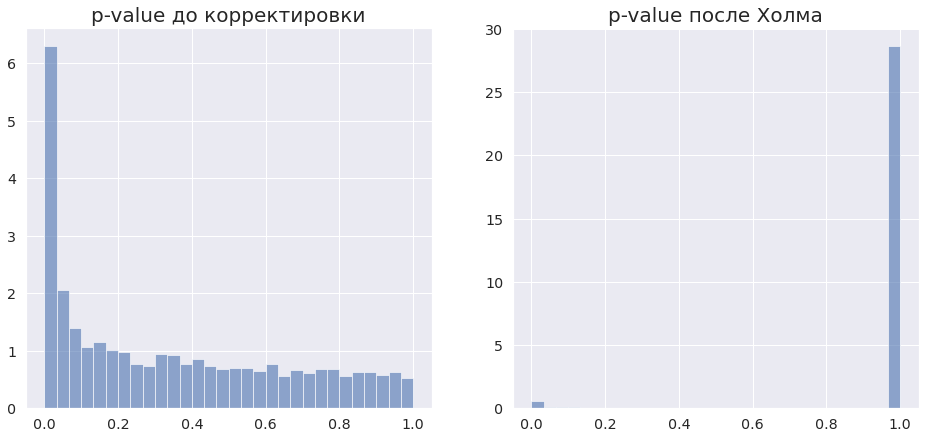

In [309]:
plt.figure(figsize=(16, 7))
plt.subplot(1,2,1)
plt.hist(p_vals_st, bins=30, density=True, alpha=0.6)
plt.title(r'p-value до корректировки', fontsize=20)

plt.subplot(1,2,2)
plt.hist(p_vals_st_2, bins=30, density=True, alpha=0.6)
plt.title(r'p-value после Холма', fontsize=20)

Напечатайте число генов, для которых можно отвергнуть нулевую гипотезу, а также их долю среди всех генов.

In [304]:
print(p_vals_st_2[p_vals_st_2<=0.05].shape[0])
print(np.round(p_vals_st_2[p_vals_st_2<=0.05].shape[0]/n,3))

145
0.022


Посмотрим, какие же гены оверэкспрессированы. В коде ниже `p_vals_adjusted` &mdash; скорректированные значения p-value.

In [305]:
for name, function in zip(
    expr_data.columns[np.where([p_vals_st_2 < 0.05])[1]], 
    descr[np.where([p_vals_st_2 < 0.05])[1]]
):
    print(name + ": " + function)

D00137: "Human class I alcohol dehydrogenase beta-1 subunit, allele 1 mRNA, complete cds"
D14678: "Human mRNA for kinesin-related protein, partial cds"
D15049: Human mRNA for protein tyrosine phosphatase
D21262: "Human mRNA for KIAA0035 gene, partial cds"
D31766: "Human mRNA for KIAA0060 gene, complete cds"
D31885: "Human mRNA for KIAA0069 gene, partial cds"
D42047: "Human mRNA for KIAA0089 gene, partial cds"
D63874: "Human mRNA for HMG-1, complete cds"
H01420: yi99d09.s1 Homo sapiens cDNA clone 147377 3' similar to gb:M68840 AMINE OXIDASE (HUMAN);
H02613: yj41e03.s1 Homo sapiens cDNA clone 151324 3'
H06524: "yl78h01.s1 Homo sapiens cDNA clone 44386 3' similar to gb:X04412 GELSOLIN PRECURSOR, PLASMA (HUMAN);"
H09351: yl95g07.s1 Homo sapiens cDNA clone 46019 3' similar to gb:D28480 MCM3 HOMOLOG (HUMAN);
H10671: yl99f12.s1 Homo sapiens cDNA clone 46344 3'
H14506: ym18f10.s1 Homo sapiens cDNA clone 48421 3'
H20709: "yn63h10.s1 Homo sapiens cDNA clone 173155 3' similar to gb:M22918 MYOSIN 

**Вывод**

**Получили 145 генов, для которых есть разница в профилях экспрессий между опухолевыми и контрольными образцами, что составляет 2.2% от общего числа генов . МПГ здесь существенна, так как проверяется большое число гипотез, что подтверждается отсечением большого числа значений на гистограмме**